# Celltype refinement

Cell types are defined as concepts with hierarchical relationships. For example, CD4+ T cell is a type of T cell. Therefore, when performing omics cell annotation, the results of cell annotation at different levels are often determined according to requirements. This makes the sub-celltype refinement a very important task. In some analyses, after routine annotation, further subdivision of cell subsets is required. Here, we demonstrate how to use BRICK for the sub-celltype refinement, further dividing pancreatic endocrine cell into pancreatic PP cell and pancreatic D cell.

## Load packages and data

In [1]:
import BRICK
import scanpy as sc

url = "neo4j://10.224.28.66:7687"
auth = ("neo4j", "bmVvNGpwYXNzd29yZA==")  

BRICK.config(url=url, auth=auth)

In [2]:
adata = sc.read('../KG_annotation/adata_new1.h5ad')
adata.X = adata.layers['lognorm'].copy()

D:\Anaconda\envs\LLM\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


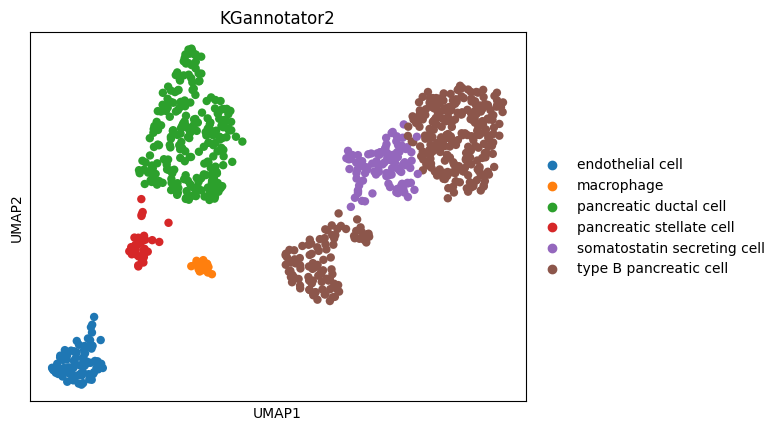

In [10]:
sc.pl.umap(adata, color = 'KGannotator2')

## sub-celltype refinement

Obviouslly, *somatostatin secreting cell* is a general cell type. From cell type annotation result we noticed that both *pancreatic D cell* and *pancreatic PP cell* are candidata cell type, which indicate these cell cluster might be a mixture of these two cell types. Thus, we use these two cell type as candidate celltypes.

In [3]:
candidate_celltypes = ['pancreatic D cell', 'pancreatic PP cell']

query_df = BRICK.qr.query_neighbor(candidate_celltypes, relation='marker_of', target_entity_type='Gene')
query_df.head()

,path.0.def,path.0.id,path.0.name,path.0.synonym,path.0.type,path.1,path.1.condition,path.1.info_source,path.1.info_source_length,path.1.original_relation,path.1.relation,path.1.relation_confidence,path.2.def,path.2.id,path.2.name,path.2.synonym,path.2.type
0,A D cell located in the pancreas. Peripherally...,CL:0000173,pancreatic D cell,D-cell of pancreatic islet|delta cell of islet...,Cell,marker_of,[UBERON:0001264],[Cell_Taxonomy:PanglaoDB],1,[marker_of],marker_of,[1],Sstr2 somatostatin receptor 2<loc>:11 E2|11 79...,NCBI:20606,Sstr2,SRIF-1|SS2R|SSTR-2|Smstr-2|Smstr2|Somatostatin...,Gene
1,A PP cell located in the islets of the pancrea...,CL:0002275,pancreatic PP cell,pancreatic polypeptide-secreting cell|PP cell ...,Cell,marker_of,[UBERON:0001264],[SCT000000966],1,[DEG_of],marker_of,[0.471],Hdac6 histone deacetylase 6<loc>:X A1.1|X 3.58...,NCBI:15185,Hdac6,Hd6|Hdac5|Histone deacetylase 6|Sfc6|mHDA2,Gene
2,A D cell located in the pancreas. Peripherally...,CL:0000173,pancreatic D cell,D-cell of pancreatic islet|delta cell of islet...,Cell,marker_of,"[UBERON:0001911, UBERON:0001981, UBERON:000126...",[SCT000000793],1,[DEG_of],marker_of,[0.9057],"arginase, liver<loc>:10 A4|10 12.26 cM<xref>MG...",NCBI:11846,Arg1,AI|Arg-1|PGIF,Gene
3,A PP cell located in the islets of the pancrea...,CL:0002275,pancreatic PP cell,pancreatic polypeptide-secreting cell|PP cell ...,Cell,marker_of,[UBERON:0001264],[SCT000000967],1,[DEG_of],marker_of,[0.5799],aristaless related homeobox<loc>:X C3|X 41.05 ...,NCBI:11878,Arx,Arx1,Gene
4,A D cell located in the pancreas. Peripherally...,CL:0000173,pancreatic D cell,D-cell of pancreatic islet|delta cell of islet...,Cell,marker_of,[Undef],[Cell_Taxonomy:OnClass:PMID:34548483],1,[marker_of],marker_of,[1],neurogenin 3<loc>:10 B4|10 32.35 cM<xref>ENSEM...,NCBI:11925,Neurog3,Atoh5|Math4B|bHLHa7|ngn3,Gene


### get the gene_list by intersection of KG and Omics

In [4]:
genelist = list(set(adata.var_names) & set(query_df['path.2.name']))

adata_sub = adata[adata.obs['KGannotator2'] == 'somatostatin secreting cell', genelist].copy()

query_df = query_df.loc[query_df['path.2.name'].isin(genelist)]

cell2marker = {x:set(y['path.2.name']) for x, y in query_df.groupby('path.0.name')}

### marker distribution visualization

Just check the marker distribution of different cell types, not necessary

(<matplotlib.patches.Circle at 0x184ed481d90>,
 <matplotlib.patches.Circle at 0x184ed481e20>)

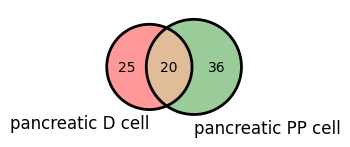

In [5]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles

plt.figure(figsize = (2,2))
venn_diagram = venn2(cell2marker.values(), set_labels=cell2marker.keys())
# 添加圆圈
venn2_circles(cell2marker.values())

## Construct a graph combine Knowledge Graph with Omics

In [77]:
nxg = BRICK.pp.combine_graph(adata=adata_sub, df=query_df, kg_reverse_direct=True, cell_neighbor=True)
len(nxg.nodes())

186

(T): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [00:28<00:00, 41.58it/s, loss=3.2]


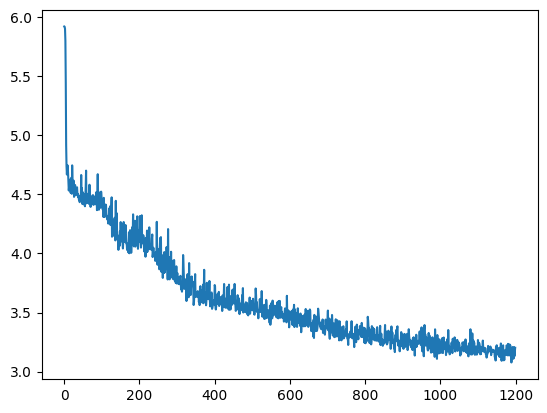

In [306]:
model = BRICK.emb.GRACE_model(nxg=nxg, lr=0.01)
model.fit(epoches=1200)
model.plot_loss()

In [307]:
adata_graph = model.get_result()

D:\Anaconda\envs\LLM\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


D:\Anaconda\envs\LLM\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


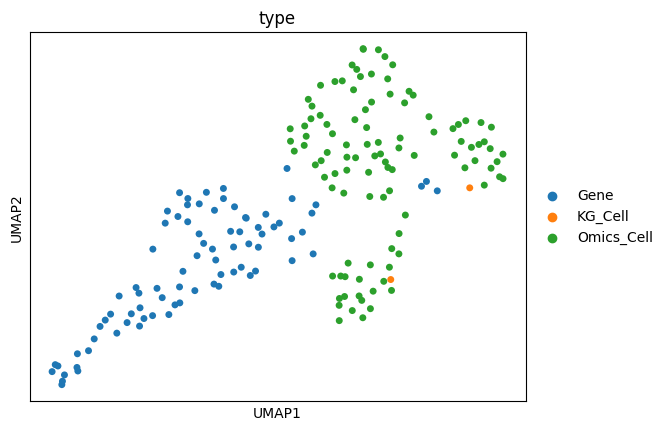

In [308]:
sc.pl.umap(adata_graph, color = 'type', s=100)

## use euclidean distance to get sub-celltype refinement

In [309]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [310]:
adata_graph_KG = adata_graph[adata_graph.obs['type'] == 'KG_Cell']
adata_graph_Omics = adata_graph[adata_graph.obs['type'] == 'Omics_Cell']


emb1 = adata_graph_KG.X
emb2 = adata_graph_Omics.X
#dist = cosine_similarity(emb1, emb2)
dist = np.array([ np.linalg.norm(emb2 - x, axis=1) for x in emb1])

dist_map = pd.DataFrame(dist)
dist_map.index = adata_graph_KG.obs_names
dist_map.columns = adata_graph_Omics.obs_names

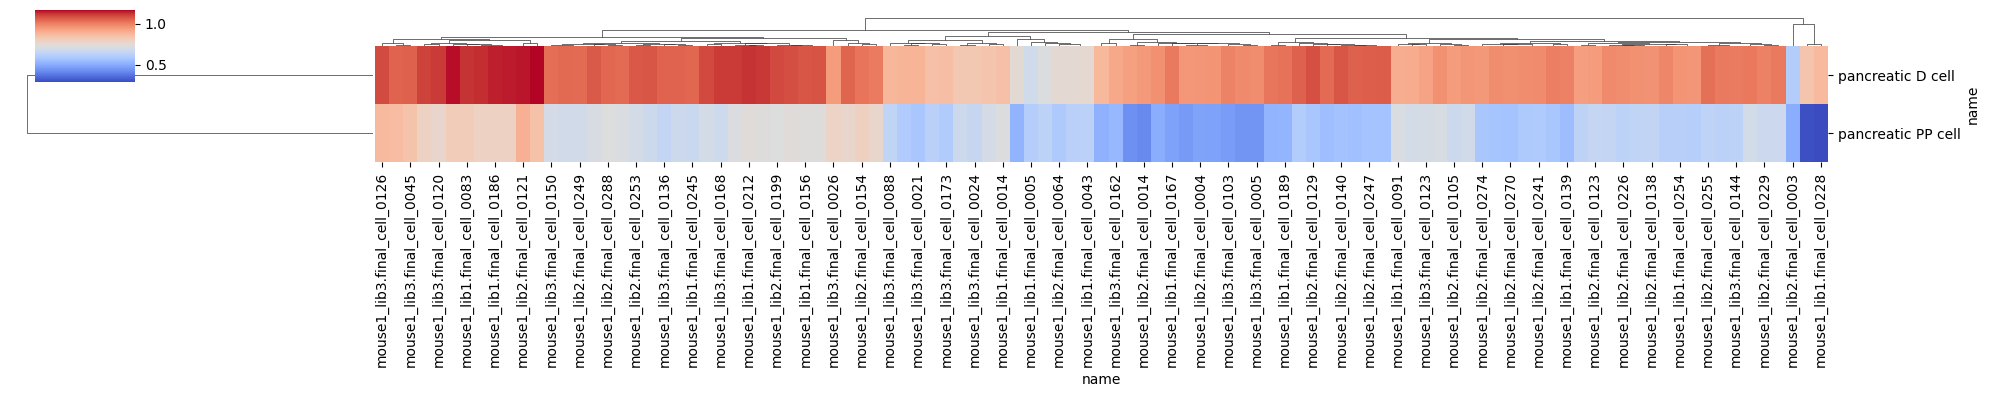

In [311]:
sns.clustermap(dist_map, figsize=(20, 4), cmap='coolwarm')

In [312]:
for x in dist_map.T:
    adata_sub.obs[x+'_dist'] = dist_map.T[x]

adata_sub.obs['dist'] = adata_sub.obs['pancreatic D cell_dist'] - adata_sub.obs['pancreatic PP cell_dist']

(array([0.9711019 , 0.48555095, 1.45665285, 1.45665285, 0.9711019 ,
        0.9711019 , 0.97110118, 2.9133057 , 0.97110262, 1.9422038 ,
        1.45665285, 1.9422038 , 4.85550226, 6.31216235, 3.8844076 ,
        4.8555095 , 1.9422038 , 0.9711019 , 0.9711019 , 0.48555095,
        3.39885665, 2.42775837, 1.94220091, 0.97110335, 0.48555023]),
 array([0.07865274, 0.09864804, 0.11864334, 0.13863865, 0.15863395,
        0.17862925, 0.19862455, 0.21861987, 0.23861517, 0.25861046,
        0.27860576, 0.29860106, 0.31859636, 0.33859169, 0.358587  ,
        0.3785823 , 0.3985776 , 0.4185729 , 0.4385682 , 0.45856351,
        0.47855881, 0.49855411, 0.51854938, 0.53854471, 0.55853999,
        0.57853532]),
 <BarContainer object of 25 artists>)

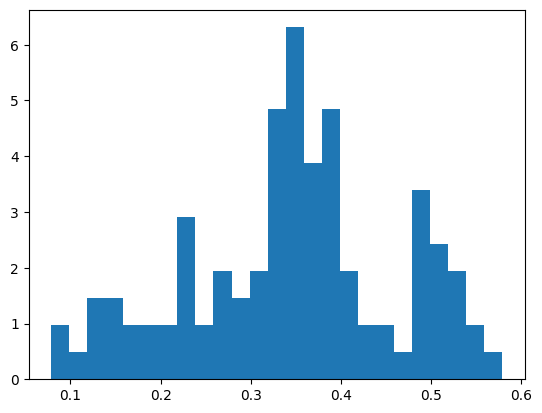

In [320]:
plt.hist(adata_sub.obs['dist'], density=True, bins =25)

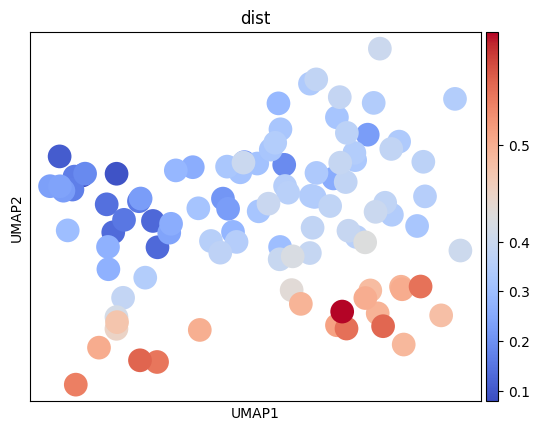

In [329]:
sc.pl.umap(adata_sub, color='dist', vcenter=0.45, cmap='coolwarm') 

D:\Anaconda\envs\LLM\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


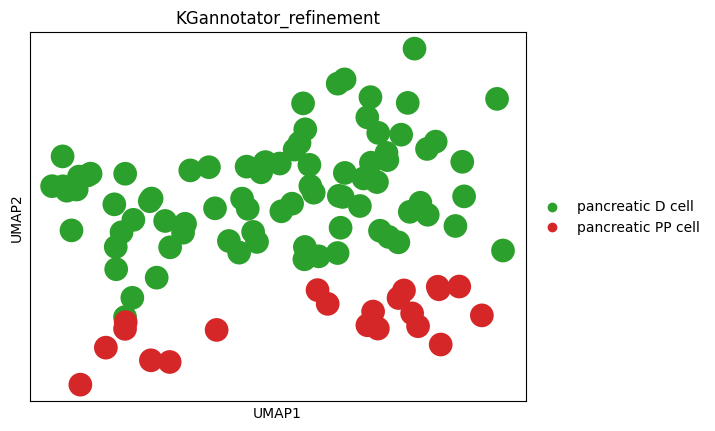

In [317]:
adata_sub.obs['KGannotator_refinement'] = ['pancreatic PP cell' if d > 0.45 else 'pancreatic D cell' for d in adata_sub.obs['dist'] ]
sc.pl.umap(adata_sub, color='KGannotator_refinement') 

## visualize the refinement result in graph embedding space

In [327]:
name2finetype = {}
for x, y in zip(adata_sub.obs_names, adata_sub.obs['KGannotator_refinement']):
    name2finetype[x] = 'Omics ' + y


for x in genelist:
    if (x in cell2marker['pancreatic D cell']) and  (x in cell2marker['pancreatic PP cell']):
        name2finetype[x] = 'intersection Gene' 
    elif (x in cell2marker['pancreatic D cell']):
        name2finetype[x] = 'pancreatic D cell Gene' 
    elif (x in cell2marker['pancreatic PP cell']):
        name2finetype[x] = 'pancreatic PP cell Gene' 

for x in cell2marker:
    name2finetype[x] = x+'type'

adata_graph.obs['finetype'] = [name2finetype[x] for x in adata_graph.obs['name']]
adata_graph.obs['size'] = [400 if x == 'KG_Cell' else 80 for x in adata_graph.obs['type']]

D:\Anaconda\envs\LLM\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


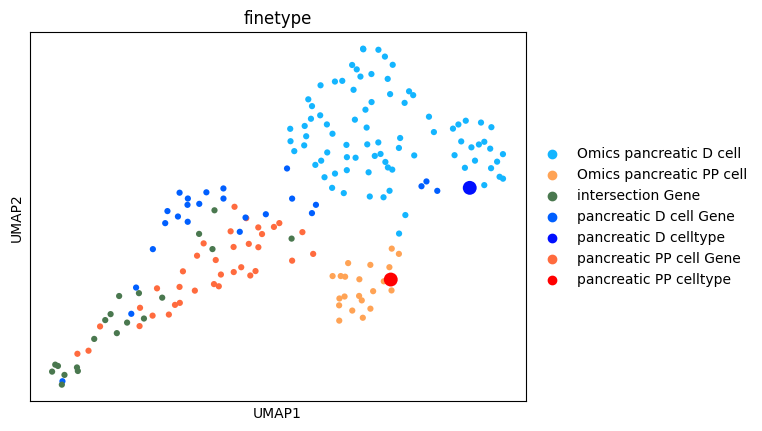

In [328]:
adata_graph.uns['finetype_colors'] = ['#14b5ff', '#ffa355', '#4a784f', '#005fff', '#000fff', '#ff6b3e', '#ff0000']
sc.pl.umap(adata_graph, color = 'finetype', s=adata_graph.obs['size'])